In [98]:
# named imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# unnamed imports
import joblib
import re

# imported functions and methods
from collections import Counter, defaultdict
from itertools import combinations

from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, classification_report, mean_square_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC

from wordcloud import WordCloud

In [2]:
# Import of the dataset and short overview of the first 10 entries.
df = pd.read_csv("../data/raw/retail_2010_2011.csv", sep=",", encoding="latin-1")
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047.0,United Kingdom


In [3]:
# Overview of the most important informations like number of the feature, name of the column, counts of no NaN and type. 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [4]:
# Display of length (Entries) and width (Features) of the dataset.
df.shape

(541909, 8)

In [5]:
# Overview of a simple statistical description of the numerical features.
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [6]:
# Overview of a simple analysis of the categorical features.
df.describe(include="object")

,InvoiceNo,StockCode,Description,InvoiceDate,Country
count,541909,541909,540455,541909,541909
unique,25900,4070,4223,23260,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,10/31/2011 14:41,United Kingdom
freq,1114,2313,2369,1114,495478


In [7]:
# A short overview of the amount of unique values in all features.
df.nunique()

InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
dtype: int64

In [8]:
# A short overview of the absolute number of NaNs per feature.
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [9]:
# A short overview of the relative number of NaNs per feature.
df.isnull().sum() / df.shape[0] * 100

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

541909 entries
8 features (5 categorical, 3 numerical)
- categorical features
    * ```InvoiceNo:``` object, 25900 unique entries,   no null     - Number of the invoice for a purchase
    * ```Stockcode:``` object, 4070 unique entries,    no null     - Identificationnumber for each product in stock
    * ```Description:``` object, 4223 unique entries,    1454 null   - Name or description of the product
    * ```InvoiceDate:``` object, 23260 unique entries,   no null     - timestamps of the purchased product
    * ```Country:``` object, 38 unique entries,      no null     - Name of the country the product waas purchased in
- numerical features
    * ```Quantity:``` int64,  mean 9.55 std 218,      no null     - amount of product
    * ```UnitPrice:``` float,  mean 4.61 std 97,       no null     - Price for each product
    * ```CustomerID:``` float,  4372 unique entries,    135080 null - Identificationnumber for each customer

The raw dataset has to be processed to fill or drop NaNs, and to handle outliers and extrem values.

Description has no value for further analysis because the StockCode is a label for a certain product. Additionally the InvoiceDate can be changed to type datetime.

In [10]:
# Changing the type of some features
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])   # changing type from object to datetime
df.dtypes                                             # display the type of all features

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

It is possible that the missing values in Description drop with the removal of all missing values in CustomerID.

In [11]:
# Removal of NaNs in 'CustomerID'
df_nan = df.dropna(subset=['CustomerID'])
df_nan.isna().sum()                                 # Display of additional NaNs in other features (i.e. Description)

df_nan.to_csv('../data/processed/df_nan', sep=',')  # save df after removal of NaNs

All NaN were removed and we continue with checking for duplicates.

In [12]:
# Display the number of duplicates
df_nan.duplicated().sum()

5225

In [13]:
# Removal of duplicates
df_dup = df_nan.drop_duplicates()
df_dup.duplicated().sum()                           # Display of possiblie duplicates

df_dup.to_csv('../data/processed/df_dup', sep=',')  # save df after removal of duplicates

After removal of the duplicates I check for outliers and extreme values in the numerical features.

In [14]:
# Repeation of the statistical overview for all numerical features (plus 'InvoiceNo')
df_dup.describe()

,Quantity,UnitPrice,CustomerID
count,401604.000000,401604.000000,401604.000000
mean,12.183273,3.474064,15281.160818
std,250.283037,69.764035,1714.006089
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13939.000000
50%,5.000000,1.950000,15145.000000
75%,12.000000,3.750000,16784.000000
max,80995.000000,38970.000000,18287.000000


'Quantity' and 'UnitPrice' show negative values due to cancellations or returns in the dataset. I therefore assume that a counterpart for most of these negative values is found in the positive values with the same amount. It isn't necessary to filter these special transactions because in the end the possible purchase of a customer is our target. I therefore cut off the negative values and I will limit the positive values at 1.5 times IWR of the maximum value.
'InvoiceNo' and 'CustomerID' are untouched after this processing due to their logical nature.

In [15]:
# Cut off of negative values for 'Quantity' and 'UnitPrice'
df_cancel = df_dup[(df_dup['Quantity'] <= 0) | (df_dup['UnitPrice'] <= 0.01)]   # Check for every negative value and unlogical value and collect them in df_cancel
df_cut_off = df_dup[~df_dup.isin(df_cancel).all(axis=1)]                        # Check if entry is in df_cancel and remove it from df_dup
df_cut_off.shape[0]                                                             # display the length of df_cut_off

df_cut_off.to_csv('../data/processed/df_cut_off', sep=',')                      # save df after cut_off

C:\Users\User\AppData\Local\Temp\ipykernel_67272\1717272434.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cut_off['InvoiceNo'] = df_cut_off['InvoiceNo'].astype(int)       # InvoiceNo can now be changed to integer


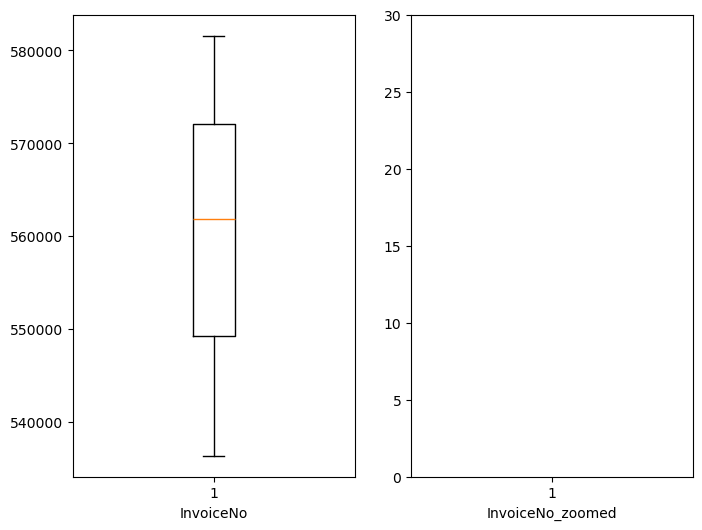

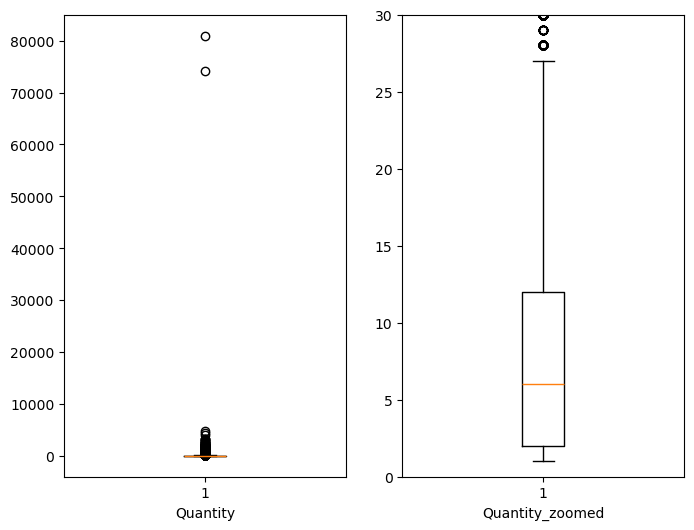

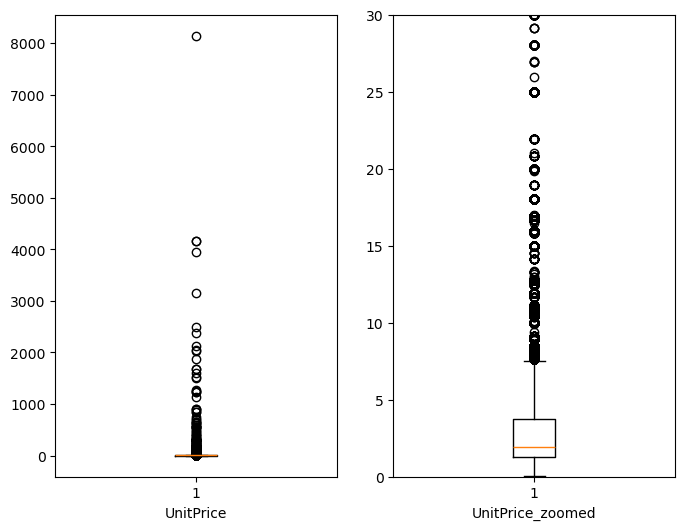

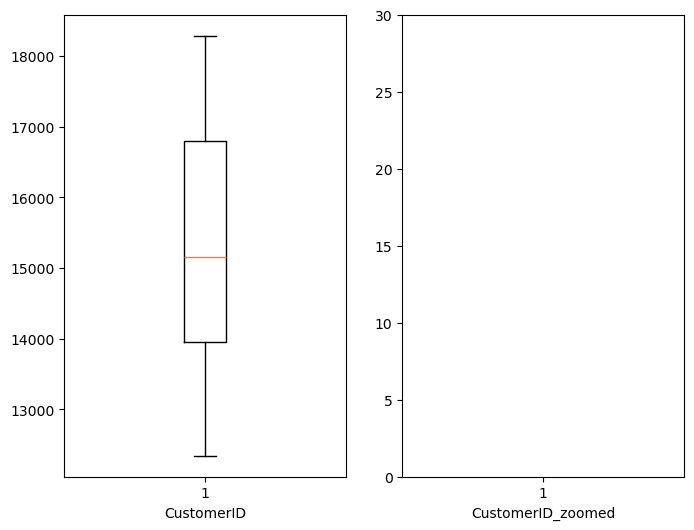

In [16]:
# Display of the numerical features graphically
df_cut_off['InvoiceNo'] = df_cut_off['InvoiceNo'].astype(int)       # InvoiceNo can now be changed to integer
df_num = df_cut_off.select_dtypes(exclude=['object', 'datetime64']) # select only the numerical features
for col in df_num.columns:                                          # loop to create a boxplot for each numerical feature
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))            # initiate a double plot (1 row, 2 columns)
    ax1.boxplot(df_num[col])                                        # initiate a boxplot for the current feature
    ax1.set_xlabel(col)                                             # set name of x-Axis

    ax2.boxplot(df_num[col])                                        # initiate a second boxplot for the current feature
    ax2.set_xlabel(col+'_zoomed')                                   # ste the name of the x-Axis and add '-zoomed'
    plt.ylim(0, 30)                                                 # limit the y-Axis
    plt.show()

In [18]:
# Function to remove outliers with input of a dataframe and the name(s) of the column(s)
def remove_outlier(df, col):                                            # df - dataframe, col - list
    for i in col:                                                       # loop over all inputed columns
        Q1 = np.quantile(df[i], 0.25)                                   # calculation of the first quartile
        Q3 = np.quantile(df[i], 0.75)                                   # calculation of the third quartile
        IQR = Q3 - Q1                                                   # calculation of the IQR (Inter Quartil Range)
        df = df[(                                                 
                (df[i] >= (Q1 - (1.5 * IQR))) &                         # capping the points to the lowest limit
                (df[i] <= (Q3 + (1.5 * IQR)))                           # capping the points to the highest limit
                )]      
    return df                                                           # return the capped df

In [88]:
# using the constructed function to remove outliers
df_outlier = remove_outlier(df_cut_off, ['Quantity'])
df_outlier.to_csv('../data/processed/df_outlier', sep=',')  # save df after remove_outlier

df_outlier.describe()                                       # check again if the values are correctly processed


,InvoiceNo,Quantity,UnitPrice,CustomerID
count,367072.000000,367072.000000,367072.000000,367072.000000
mean,560632.609613,7.094785,3.240044,15302.785960
std,13109.182666,6.670843,22.972438,1712.044642
min,536365.000000,1.000000,0.060000,12347.000000
25%,549238.000000,2.000000,1.250000,13975.000000
50%,561894.000000,4.000000,1.950000,15182.000000
75%,572103.000000,12.000000,3.750000,16807.000000
max,581587.000000,27.000000,8142.750000,18287.000000


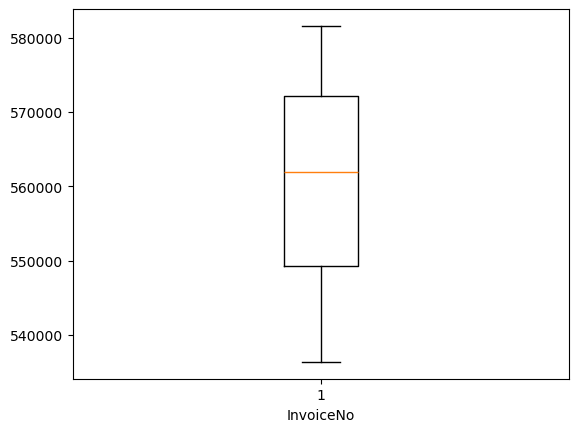

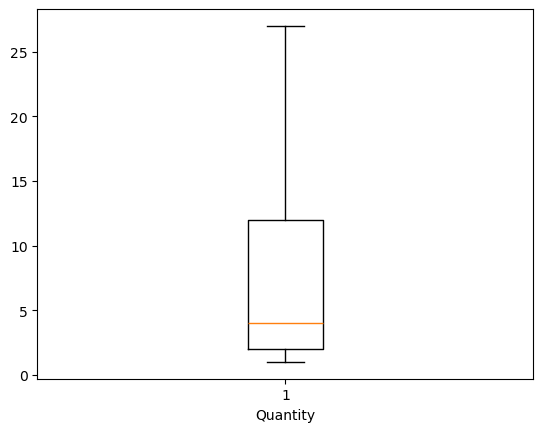

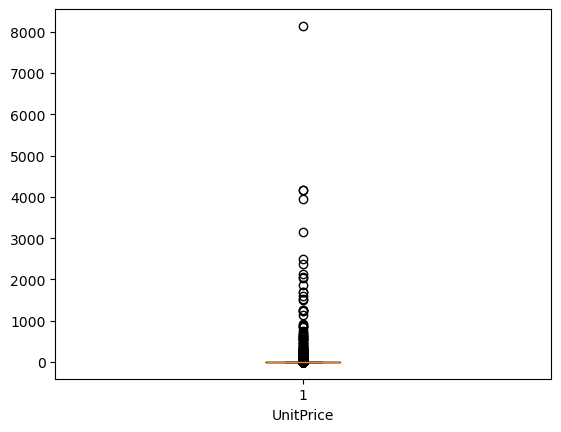

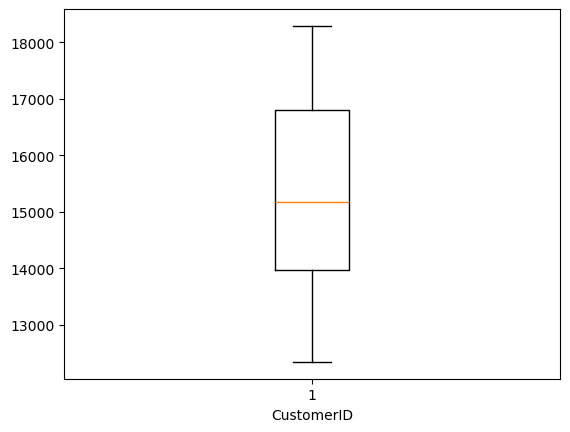

In [20]:
# Display of the numerical features graphically after remove_outliers
df_num = df_outlier.select_dtypes(exclude=['object', 'datetime64']) # extract numericals
for col in df_num.columns:                                          # loop over every numerical feature
    plt.boxplot(df_num[col])                                        # create boxplot
    plt.xlabel(col)                                                 # rename x-Axis
    plt.show()

We removed the outliers only for Quantity because CustomerId and InvoiceNo weren't effected by outliers or extreme values. Now only UnitPrice shows high values which seem odd. I therefore sort the df_outlier and try to find a reason for the high prices.

In [21]:
# sorting df_outlier after 'UnitPrice' in a descending order
df_outlier.sort_values('UnitPrice', ascending=False).groupby('UnitPrice').head(20)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
173382,551697,POST,POSTAGE,1,2011-05-03 13:46:00,8142.75,16029.0,United Kingdom
422376,573080,M,Manual,1,2011-10-27 14:20:00,4161.06,12536.0,France
422351,573077,M,Manual,1,2011-10-27 14:13:00,4161.06,12536.0,France
406406,571751,M,Manual,1,2011-10-19 11:18:00,3949.32,12744.0,Singapore
374542,569382,M,Manual,1,2011-10-03 16:44:00,3155.95,15502.0,United Kingdom
...,...,...,...,...,...,...,...,...
517015,580027,16219,HOUSE SHAPE PENCIL SHARPENER,15,2011-12-01 12:01:00,0.06,14178.0,United Kingdom
439780,574481,16218,CARTOON PENCIL SHARPENERS,5,2011-11-04 12:45:00,0.06,18022.0,United Kingdom
494885,578278,16219,HOUSE SHAPE PENCIL SHARPENER,21,2011-11-23 13:51:00,0.06,12748.0,United Kingdom
476270,577008,16216,LETTER SHAPE PENCIL SHARPENER,10,2011-11-17 12:02:00,0.06,16869.0,United Kingdom


All of the lettered codes in StockCodes have aren't necessary for the task ahead and I therefore remove them

In [22]:
# removal of lettered codes in 'StockCode'
df_cleaned = df_outlier[~df_outlier['StockCode'].str.contains('[A-Za-z]')]  # filter the df of lettered codes and remove them

df_cleaned.to_csv('../data/processed/df_cleaned', sep=',')                  # save df as cleaned after preprocesing

In [23]:
# final check
df_cleaned.sort_values('UnitPrice', ascending=False).head(20)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
222682,556446,22502,PICNIC BASKET WICKER 60 PIECES,1,2011-06-10 15:33:00,649.5,15098.0,United Kingdom
171178,551393,22656,VINTAGE BLUE KITCHEN CABINET,1,2011-04-28 12:22:00,295.0,14973.0,United Kingdom
205759,554836,22655,VINTAGE RED KITCHEN CABINET,1,2011-05-26 16:25:00,295.0,13015.0,United Kingdom
32484,539080,22655,VINTAGE RED KITCHEN CABINET,1,2010-12-16 08:41:00,295.0,16607.0,United Kingdom
133994,547814,22656,VINTAGE BLUE KITCHEN CABINET,1,2011-03-25 14:19:00,295.0,13452.0,United Kingdom
51636,540647,22655,VINTAGE RED KITCHEN CABINET,1,2011-01-10 14:57:00,295.0,17406.0,United Kingdom
118769,546480,22656,VINTAGE BLUE KITCHEN CABINET,1,2011-03-14 11:38:00,295.0,13452.0,United Kingdom
82768,543253,22655,VINTAGE RED KITCHEN CABINET,1,2011-02-04 15:32:00,295.0,14842.0,United Kingdom
4989,536835,22655,VINTAGE RED KITCHEN CABINET,1,2010-12-02 18:06:00,295.0,13145.0,United Kingdom
220298,556181,22826,LOVE SEAT ANTIQUE WHITE METAL,1,2011-06-09 11:32:00,195.0,15407.0,United Kingdom


First attempt:

An statistical approach with a groupby() by InvoiceID plus a value_count() on the grouped data can give a possible recommandation for a bundle.

In [24]:
# copy the cleaned df for further operations
df_word = df_cleaned.copy()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom


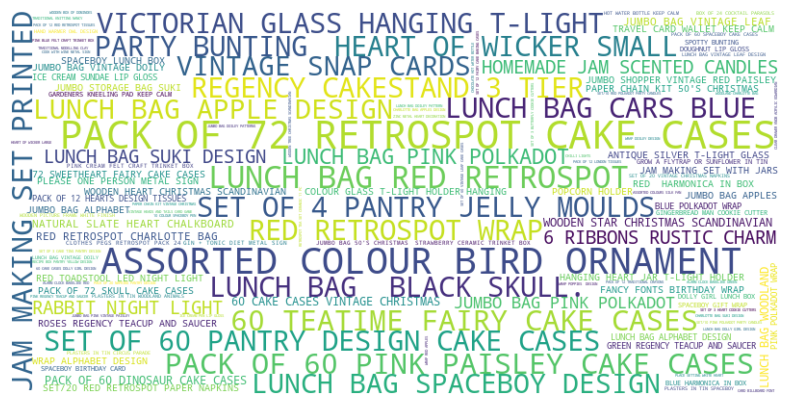

In [25]:
# creataing a word cloud
word_counts = df_word.groupby('Description')['Quantity'].sum()          # count the amount of different description
wordcloud = WordCloud(width=800, height=400, background_color='white')\
    .generate_from_frequencies(word_counts)                             # create a word cloud based on the relative amount

plt.figure(figsize=(10, 5))                                             # create a figure for the word cloud
plt.imshow(wordcloud, interpolation='bilinear')                         # build the word cloud
plt.axis('off')                                                         # dont display the axis
plt.show()

Through the wordcloud I can ssee that "white hanging heart T-Light holder" is the most common one and several other product have a similiar word size. I therefore want to compare the absolute number of the Top20 porducts which one could create bundles of.

In [26]:
# show the total amount of products counted
print(word_counts.sort_values(ascending=False).head(20))

Description
PACK OF 72 RETROSPOT CAKE CASES        14986
ASSORTED COLOUR BIRD ORNAMENT          13574
LUNCH BAG RED RETROSPOT                 9776
JAM MAKING SET PRINTED                  8671
PACK OF 60 PINK PAISLEY CAKE CASES      8498
60 TEATIME FAIRY CAKE CASES             8376
VICTORIAN GLASS HANGING T-LIGHT         7601
RED RETROSPOT WRAP                      7447
REGENCY CAKESTAND 3 TIER                7425
LUNCH BAG  BLACK SKULL.                 7328
HEART OF WICKER SMALL                   7230
SET OF 4 PANTRY JELLY MOULDS            7137
PARTY BUNTING                           7097
LUNCH BAG CARS BLUE                     7018
SET OF 60 PANTRY DESIGN CAKE CASES      6981
LUNCH BAG SPACEBOY DESIGN               6845
VINTAGE SNAP CARDS                      6793
LUNCH BAG APPLE DESIGN                  6780
LUNCH BAG PINK POLKADOT                 6696
HOMEMADE JAM SCENTED CANDLES            6536
Name: Quantity, dtype: int64


With this Top20 table I can assume, that a bundle out of in example the first 2 to 5 products will satisfy most of possible new customers.

I add the TotalPrice per purchase for possible analysis later on.

In [89]:
# calculating the 'TotalPrice' for each purchase based on 'UnitPrice' and 'Quantity'
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * df_cleaned['Quantity']
df_cleaned.sort_values('TotalPrice', ascending=False).head(20)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
222682,556446,22502,PICNIC BASKET WICKER 60 PIECES,1,2011-06-10 15:33:00,649.50,15098.0,United Kingdom,649.50
16437,537659,21769,VINTAGE POST OFFICE CABINET,10,2010-12-07 16:43:00,52.77,18102.0,United Kingdom,527.70
490300,578042,22826,LOVE SEAT ANTIQUE WHITE METAL,6,2011-11-22 14:25:00,85.00,17500.0,United Kingdom,510.00
451242,575189,22504,CABIN BAG VINTAGE RETROSPOT,18,2011-11-09 09:13:00,24.95,13029.0,United Kingdom,449.10
468546,576512,22823,CHEST NATURAL WOOD 20 DRAWERS,4,2011-11-15 12:09:00,110.00,15524.0,United Kingdom,440.00
61549,541426,22823,CHEST NATURAL WOOD 20 DRAWERS,4,2011-01-18 08:44:00,110.00,18233.0,United Kingdom,440.00
398632,571255,23064,CINDERELLA CHANDELIER,10,2011-10-14 17:13:00,41.75,12454.0,Spain,417.50
407338,571864,23009,I LOVE LONDON BABY GIFT SET,24,2011-10-19 13:49:00,14.95,12731.0,France,358.80
121725,546780,23008,DOLLY GIRL BABY GIFT SET,24,2011-03-17 07:40:00,14.95,12435.0,Denmark,358.80
121724,546780,23010,CIRCUS PARADE BABY GIFT SET,24,2011-03-17 07:40:00,14.95,12435.0,Denmark,358.80


For calculating the prices of possible bundles I created several dataframes first and combined them later on. I start with combining the Top100 products in pairs, create a dataframe for the Unitprice and the amount of Quantitiy purchased for every product. Afterwards I associate every item in the bundle with their UnitPrice and highest Quantity purchased. At the end i calcuate the totalprice for each bundle. 

In [90]:
# create bundles with a pair of products
top_100_per_product = df_cleaned.groupby('Description')['Quantity'].sum().nlargest(100) # create a dataframe with the top100 products
product_combinations = list(combinations(top_100_per_product.index, 2))                 # combine the products to bundles

bundle_products = []                                                                    # initiate a list
for bundle in product_combinations:                                                     # loop over every product in the bundle
    bundle_products.append((bundle[0], bundle[1]))                                      # add the pundle to the list

bundles_top_df = pd.DataFrame(bundle_products, columns=['Product1', 'Product2'])        # save the bundles in a dataframe

In [91]:
# Display the combinations
bundles_top_df.head(10)

,Product1,Product2
0,PACK OF 72 RETROSPOT CAKE CASES,ASSORTED COLOUR BIRD ORNAMENT
1,PACK OF 72 RETROSPOT CAKE CASES,LUNCH BAG RED RETROSPOT
2,PACK OF 72 RETROSPOT CAKE CASES,JAM MAKING SET PRINTED
3,PACK OF 72 RETROSPOT CAKE CASES,PACK OF 60 PINK PAISLEY CAKE CASES
4,PACK OF 72 RETROSPOT CAKE CASES,60 TEATIME FAIRY CAKE CASES
5,PACK OF 72 RETROSPOT CAKE CASES,VICTORIAN GLASS HANGING T-LIGHT
6,PACK OF 72 RETROSPOT CAKE CASES,RED RETROSPOT WRAP
7,PACK OF 72 RETROSPOT CAKE CASES,REGENCY CAKESTAND 3 TIER
8,PACK OF 72 RETROSPOT CAKE CASES,LUNCH BAG BLACK SKULL.
9,PACK OF 72 RETROSPOT CAKE CASES,HEART OF WICKER SMALL


In [92]:
# create a dataframe with the product and their associated 'UnitPrice'
unit_price_per_product = df_cleaned.groupby('Description')['UnitPrice'].first().reset_index()                           # filter the data
unit_price_per_product = unit_price_per_product.rename(columns={'Description': 'Product', 'UnitPrice': 'UnitPrice'})    # rename the columns

unit_price_per_product.head(10)


,Product,UnitPrice
0,50'S CHRISTMAS GIFT BAG LARGE,1.25
1,DOLLY GIRL BEAKER,1.25
2,I LOVE LONDON MINI BACKPACK,4.15
3,I LOVE LONDON MINI RUCKSACK,4.15
4,NINE DRAWER OFFICE TIDY,14.95
5,OVAL WALL MIRROR DIAMANTE,9.95
6,RED SPOT GIFT BAG LARGE,1.25
7,SET 2 TEA TOWELS I LOVE LONDON,2.95
8,SPACEBOY BABY GIFT SET,14.95
9,TOADSTOOL BEDSIDE LIGHT,8.95


In [75]:
# create a dataframe with the amount of Quantity purchased per product
quantity_counts_per_product = df_cleaned.groupby(['Description', 'Quantity']).size()    # filter the data
quantity_counts_per_product.sort_values(ascending=False).head(10)                       # display the data

Description                        Quantity
LUNCH BAG RED RETROSPOT            10          626
PACK OF 72 RETROSPOT CAKE CASES    24          576
SET OF 3 CAKE TINS PANTRY DESIGN   3           550
ASSORTED COLOUR BIRD ORNAMENT      8           546
REGENCY CAKESTAND 3 TIER           1           480
JAM MAKING SET PRINTED             12          475
NATURAL SLATE HEART CHALKBOARD     6           474
REX CASH+CARRY JUMBO SHOPPER       1           467
PARTY BUNTING                      4           457
LUNCH BAG CARS BLUE                10          450
dtype: int64

In [93]:
# combining the dataframes 
merged_df = pd.merge(bundles_top_df, quantity_counts_per_product.reset_index(),                     # merging the bundles with their quantity
                    left_on='Product1',                                                             # for product 1
                    right_on='Description')         
merged_df = merged_df.rename(columns={'Quantity': 'Quantity1'}).drop(columns=['Description'])       # rename columns and drop duplicated columns

merged_df = pd.merge(merged_df, quantity_counts_per_product.reset_index(),                          # merging the bundles with their quantity
                    left_on='Product2',                                                             # for product 1
                    right_on='Description')
merged_df = merged_df.rename(columns={'Quantity': 'Quantity2'}).drop(columns=['Description'])       # rename columns and drop duplicated columns

best_quantity_per_bundle = merged_df.groupby(['Product1', 'Product2'])\
    .agg({'Quantity1': 'max', 'Quantity2': 'max'}).reset_index()                                    # search the highest quantity for each bundle
                                                                                                    # item

In [94]:
# display dataframe
best_quantity_per_bundle.head()

,Product1,Product2,Quantity1,Quantity2
0,6 RIBBONS RUSTIC CHARM,60 CAKE CASES DOLLY GIRL DESIGN,24,24
1,6 RIBBONS RUSTIC CHARM,60 CAKE CASES VINTAGE CHRISTMAS,24,24
2,6 RIBBONS RUSTIC CHARM,72 SWEETHEART FAIRY CAKE CASES,24,24
3,6 RIBBONS RUSTIC CHARM,ALARM CLOCK BAKELIKE RED,24,24
4,6 RIBBONS RUSTIC CHARM,ANTIQUE SILVER T-LIGHT GLASS,24,24


In [95]:
# repeat the combining process with the UnitPrice
bundles_with_prices = best_quantity_per_bundle.merge(unit_price_per_product, left_on='Product1', right_on='Product', how='left')
bundles_with_prices = bundles_with_prices.rename(columns={'UnitPrice': 'UnitPrice1'}).drop(columns=['Product'])
bundles_with_prices = bundles_with_prices.merge(unit_price_per_product, left_on='Product2', right_on='Product', how='left')
bundles_with_prices = bundles_with_prices.rename(columns={'UnitPrice': 'UnitPrice2'}).drop(columns=['Product'])

bundles_with_prices.head(10)

,Product1,Product2,Quantity1,Quantity2,UnitPrice1,UnitPrice2
0,6 RIBBONS RUSTIC CHARM,60 CAKE CASES DOLLY GIRL DESIGN,24,24,1.65,0.55
1,6 RIBBONS RUSTIC CHARM,60 CAKE CASES VINTAGE CHRISTMAS,24,24,1.65,0.55
2,6 RIBBONS RUSTIC CHARM,72 SWEETHEART FAIRY CAKE CASES,24,24,1.65,0.55
3,6 RIBBONS RUSTIC CHARM,ALARM CLOCK BAKELIKE RED,24,24,1.65,3.75
4,6 RIBBONS RUSTIC CHARM,ANTIQUE SILVER T-LIGHT GLASS,24,24,1.65,1.25
5,6 RIBBONS RUSTIC CHARM,BLUE HARMONICA IN BOX,24,24,1.65,1.25
6,6 RIBBONS RUSTIC CHARM,BLUE POLKADOT WRAP,24,25,1.65,0.42
7,6 RIBBONS RUSTIC CHARM,BOX OF 24 COCKTAIL PARASOLS,24,25,1.65,0.42
8,6 RIBBONS RUSTIC CHARM,CHARLOTTE BAG SUKI DESIGN,24,20,1.65,0.85
9,6 RIBBONS RUSTIC CHARM,CLOTHES PEGS RETROSPOT PACK 24,24,24,1.65,1.49


In [96]:
# calculate the TotalPrice of each bundle
bundles_with_prices['TotalPrice'] = bundles_with_prices['Quantity1'] * bundles_with_prices['UnitPrice1'] + bundles_with_prices['Quantity2'] * bundles_with_prices['UnitPrice2']

bundles_with_prices.head(10)

,Product1,Product2,Quantity1,Quantity2,UnitPrice1,UnitPrice2,TotalPrice
0,6 RIBBONS RUSTIC CHARM,60 CAKE CASES DOLLY GIRL DESIGN,24,24,1.65,0.55,52.80
1,6 RIBBONS RUSTIC CHARM,60 CAKE CASES VINTAGE CHRISTMAS,24,24,1.65,0.55,52.80
2,6 RIBBONS RUSTIC CHARM,72 SWEETHEART FAIRY CAKE CASES,24,24,1.65,0.55,52.80
3,6 RIBBONS RUSTIC CHARM,ALARM CLOCK BAKELIKE RED,24,24,1.65,3.75,129.60
4,6 RIBBONS RUSTIC CHARM,ANTIQUE SILVER T-LIGHT GLASS,24,24,1.65,1.25,69.60
5,6 RIBBONS RUSTIC CHARM,BLUE HARMONICA IN BOX,24,24,1.65,1.25,69.60
6,6 RIBBONS RUSTIC CHARM,BLUE POLKADOT WRAP,24,25,1.65,0.42,50.10
7,6 RIBBONS RUSTIC CHARM,BOX OF 24 COCKTAIL PARASOLS,24,25,1.65,0.42,50.10
8,6 RIBBONS RUSTIC CHARM,CHARLOTTE BAG SUKI DESIGN,24,20,1.65,0.85,56.60
9,6 RIBBONS RUSTIC CHARM,CLOTHES PEGS RETROSPOT PACK 24,24,24,1.65,1.49,75.36


I received a dataframe with every bundle, their highest Quantity per product and TotalPrice for each bundle.

The last part is an addition to the recommandation of products based on bundle. I used a machine learning approach. I start with calculation a Top1000 bundles list based on the purchased product combinations per InvoiceNo.

Note: Many steps were processed earlier and sometimes there is no or an incorrect output but most models and df are saved and loaded.

In [99]:
# creating a Top1000 bundle list
grouped = df_cleaned.groupby(['CustomerID', 'InvoiceNo'])               # grouping the dataframe

def collect_items_quantity(items):                                      # function to collect the quantity of purchased items
    return Counter(zip(items['StockCode'], items['Quantity']))

invoice_items_quantities = grouped.apply(collect_items_quantity)        # collect the data based on collect_items_quantity

def identify_bundles(items_quantities):                                 # function to identify possible bundles
    bundles = []                                                        # initiate list
    items = list(items_quantities.keys())                               # create list with keys from the imported list
    for bundle in combinations(items, 2):                               # loop over pairing the bundles
        total_quantity = sum([qty for _, qty in bundle])                # delete [0] and [1]
        if total_quantity >= 2:                                         # add the item to the bundle if the quantity is 2 or higher 
            bundles.append(tuple(sorted(bundle)))                       
    return bundles                                                      # return the list of bundles

bundles_per_invoice = invoice_items_quantities.apply(identify_bundles)  # identify every bundle per InvoiceNo
bundle_counts = defaultdict(int)

for bundles in bundles_per_invoice:                                     # loop over every bundle in the list
    for bundle in bundles:                                              # loop over every item in the bundle
        sorted_bundle = tuple(sorted(bundle))                           # sorting the products in bundle to get unique combinations
        bundle_counts[sorted_bundle] += 1                               # increase for the unique combination
        
        reverse_bundle = tuple(reversed(sorted_bundle))                 # check if there is a reversed combination of an unique bundle
        if reverse_bundle in bundle_counts:                             # if there is one increase the number of the existing unique combination
            bundle_counts[sorted_bundle] += bundle_counts[reverse_bundle]

bundle_counter = Counter(bundle_counts)                                 # filter the Top 1000 bundles
top_1000_bundles = bundle_counter.most_common(1000)

In [100]:
# display the top1000 bundles with their stockcode and quantity purchased
top_1000_bundles

[((('22697', 6), ('22699', 6)), 241),
 ((('22697', 6), ('22698', 6)), 222),
 ((('20725', 10), ('22384', 10)), 199),
 ((('22698', 6), ('22699', 6)), 197),
 ((('20725', 10), ('22383', 10)), 193),
 ((('23203', 10), ('23209', 10)), 183),
 ((('23202', 10), ('23203', 10)), 181),
 ((('20728', 10), ('22383', 10)), 181),
 ((('20725', 10), ('20727', 10)), 180),
 ((('20725', 10), ('20728', 10)), 177),
 ((('22629', 12), ('22630', 12)), 174),
 ((('20728', 10), ('22384', 10)), 166),
 ((('20725', 10), ('20726', 10)), 165),
 ((('20727', 10), ('22384', 10)), 165),
 ((('20725', 10), ('22382', 10)), 164),
 ((('22726', 4), ('22727', 4)), 162),
 ((('20727', 10), ('22383', 10)), 158),
 ((('20726', 10), ('22382', 10)), 156),
 ((('20725', 10), ('23206', 10)), 151),
 ((('20725', 10), ('23209', 10)), 150),
 ((('21212', 24), ('21977', 24)), 150),
 ((('22382', 10), ('22383', 10)), 147),
 ((('21212', 24), ('84991', 24)), 146),
 ((('22960', 6), ('22961', 12)), 145),
 ((('23206', 10), ('23209', 10)), 145),
 ((('2262

In [101]:
# translation of the StockCode to Description
stockcode_to_description = dict(zip(df['StockCode'], df['Description']))                                    # create a dictionary

top_1000_bundles_items = []                                                                                 # initiate lists
bundle_counter_items = []

for bundle, count in top_1000_bundles:                                                                      # loop over every bundle
    bundle_with_descriptions = [(stockcode_to_description[item], quantity) for item, quantity in bundle]    # translate StockCode into
    top_1000_bundles_items.append((bundle_with_descriptions, count))                                        # describtion

In [103]:
# display the translated top 1000 bundles
top_1000_bundles_items

[([('GREEN REGENCY TEACUP AND SAUCER', 6),
   ('ROSES REGENCY TEACUP AND SAUCER ', 6)],
  241),
 ([('GREEN REGENCY TEACUP AND SAUCER', 6),
   ('PINK REGENCY TEACUP AND SAUCER', 6)],
  222),
 ([('LUNCH BAG RED RETROSPOT', 10), ('LUNCH BAG PINK POLKADOT', 10)], 199),
 ([('PINK REGENCY TEACUP AND SAUCER', 6),
   ('ROSES REGENCY TEACUP AND SAUCER ', 6)],
  197),
 ([('LUNCH BAG RED RETROSPOT', 10), ('LUNCH BAG SUKI DESIGN ', 10)], 193),
 ([('JUMBO BAG VINTAGE DOILY ', 10), ('LUNCH BAG VINTAGE DOILY ', 10)], 183),
 ([('JUMBO BAG VINTAGE LEAF', 10), ('JUMBO BAG VINTAGE DOILY ', 10)], 181),
 ([('LUNCH BAG CARS BLUE', 10), ('LUNCH BAG SUKI DESIGN ', 10)], 181),
 ([('LUNCH BAG RED RETROSPOT', 10), ('LUNCH BAG  BLACK SKULL.', 10)], 180),
 ([('LUNCH BAG RED RETROSPOT', 10), ('LUNCH BAG CARS BLUE', 10)], 177),
 ([('SPACEBOY LUNCH BOX ', 12), ('DOLLY GIRL LUNCH BOX', 12)], 174),
 ([('LUNCH BAG CARS BLUE', 10), ('LUNCH BAG PINK POLKADOT', 10)], 166),
 ([('LUNCH BAG RED RETROSPOT', 10), ('LUNCH BAG WO

Testcode for the recommendation process

In [108]:
a = 'GREEN REGENCY TEACUP AND SAUCER'

for bundle, count in top_1000_bundles_items:                    # loop over every bundle
    print("Bundle:", bundle, ' Count:', count)                  # print the bundle
    for item in bundle:                                         # loop over every item in bundle
        item_description = item[0]                              # item in bundle
        #item_quantity = item[1]                                # quantity of item in bundle
        if a in item_description:
            #print("Found:", a, "in item:", item_description)   # print a check for a 
            if a == bundle[0][0]:                               # if a is first item in bundle
                print('Recommend: ', bundle[1][0], '\n')              # recommend the second item
            elif a == bundle[1][0]:                             # vice versa
                print('Recommend: ', bundle[0][0], '\n')
            else:
                continue

Bundle: [('GREEN REGENCY TEACUP AND SAUCER', 6), ('ROSES REGENCY TEACUP AND SAUCER ', 6)]  Count: 241
Recommend:  ROSES REGENCY TEACUP AND SAUCER  

Bundle: [('GREEN REGENCY TEACUP AND SAUCER', 6), ('PINK REGENCY TEACUP AND SAUCER', 6)]  Count: 222
Recommend:  PINK REGENCY TEACUP AND SAUCER 

Bundle: [('LUNCH BAG RED RETROSPOT', 10), ('LUNCH BAG PINK POLKADOT', 10)]  Count: 199
Bundle: [('PINK REGENCY TEACUP AND SAUCER', 6), ('ROSES REGENCY TEACUP AND SAUCER ', 6)]  Count: 197
Bundle: [('LUNCH BAG RED RETROSPOT', 10), ('LUNCH BAG SUKI DESIGN ', 10)]  Count: 193
Bundle: [('JUMBO BAG VINTAGE DOILY ', 10), ('LUNCH BAG VINTAGE DOILY ', 10)]  Count: 183
Bundle: [('JUMBO BAG VINTAGE LEAF', 10), ('JUMBO BAG VINTAGE DOILY ', 10)]  Count: 181
Bundle: [('LUNCH BAG CARS BLUE', 10), ('LUNCH BAG SUKI DESIGN ', 10)]  Count: 181
Bundle: [('LUNCH BAG RED RETROSPOT', 10), ('LUNCH BAG  BLACK SKULL.', 10)]  Count: 180
Bundle: [('LUNCH BAG RED RETROSPOT', 10), ('LUNCH BAG CARS BLUE', 10)]  Count: 177
Bund

TypeError: argument of type 'float' is not iterable

Real function for recommending an item (time intesitive, there for an interrupted output but df afterwards was saved from a previous run)

In [ ]:
def recommend_similar_items(df, top_bundles):                               # Input of dataframe and bundle list
    recommended_items = []
    for index, row in df.iterrows():                                        # iterate over every row
        max_count = 0                                                       # counter for quantity
        best_bundle = None
        for bundle, count in top_bundles:                                   # get a bundle
            if bundle[0][0] in row['Description'] or bundle[1][0] in row['Description']:
                if count > max_count:                                       # search first or second bundle item in dataframe
                    max_count = count                                       # take over the count and the bundle
                    best_bundle = bundle
        if best_bundle:                                                     # if best bundle is found recommend the other item to the given item  
            recommended_item = best_bundle[1][0] if best_bundle[0][0] in row['Description'] else best_bundle[0][0]
            recommended_items.append((row['InvoiceNo'], row['Description'], recommended_item))
    return recommended_items                                                # return the list of recommended items

recommended_items = recommend_similar_items(df_cleaned, top_1000_bundles_items) # start the function

recommended_df = pd.DataFrame(recommended_items, columns=['InvoiceNo', 'Description', 'Recommended_Item'])  # create a dataframe

recommended_df.to_csv('C:/Users/User/OneDrive/Dokumente/GitHub/DS_FS_Conrad/data/processed/recommended_df.csv', sep=',') # save the dataframe

KeyboardInterrupt: 

In [ ]:
# merging the recommended item list with the dataframe
recommended_df = pd.read_csv('../data/processed/recommended_df.csv', sep=',')                   # load the saved dataframe
recommended_df = recommended_df.drop(recommended_df.columns[0], axis=1)                         # drop unnamed column

merged_df = pd.merge(df_cleaned, recommended_df, on=['InvoiceNo', 'Description'], how='left')   # merge dataframes
merged_df.head(10)     

(396218, 9)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Recommended_Item
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,NaN
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,NaN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,NaN
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,NaN
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,NaN
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom,NaN
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom,NaN
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom,HAND WARMER OWL DESIGN
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom,NaN
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom,PAINTED METAL PEARS ASSORTED


In [ ]:
# check for NaNs due to merging
merged_df.isna().sum()

InvoiceNo                0
StockCode                0
Description              0
Quantity                 0
InvoiceDate              0
UnitPrice                0
CustomerID               0
Country                  0
Recommended_Item    233261
dtype: int64

In [ ]:
# drop NaNs due to merging
merged_df = merged_df.dropna()
merged_df.shape

(162957, 9)

In [ ]:
# drop duplicates due to merging
merged_df = merged_df.drop_duplicates()
merged_df.shape

(159427, 9)

In [ ]:
# preparing the dataset for machine learning
StockCode_encoder = LabelEncoder()                              # initate different Encoder for converting into integer for better handling
Country_encoder = LabelEncoder()
Description_encoder = LabelEncoder()

merged_df['StockCode_numeric'] = StockCode_encoder.fit_transform(merged_df['StockCode'])    # encode StockCode
merged_df['Description_numeric'] = Description_encoder.fit_transform(merged_df['Description'])  # encode description
merged_df['Recommended_Item_numeric'] = Description_encoder.transform(merged_df['Recommended_Item']) # encode recommended item
merged_df = merged_df.set_index('InvoiceDate').drop(['StockCode', 'Description', 'Recommended_Item'], axis=1)   # set new index and drop old columns
merged_df['InvoiceNo'] = merged_df['InvoiceNo'].astype(int)    # code necessary earlier
merged_df['CustomerID'] = merged_df['CustomerID'].astype(int)  # code necessary earlier
merged_df.dtypes

InvoiceNo                     int32
Quantity                      int64
UnitPrice                   float64
CustomerID                    int32
Country                      object
StockCode_numeric             int32
Description_numeric           int32
Recommended_Item_numeric      int32
dtype: object

In [ ]:
# display of correlation matrix
corr_mat = merged_df.corr()
corr_mat2 = round(corr_mat*100, 2)
corr_mat2

C:\Users\User\AppData\Local\Temp\ipykernel_36976\2565731692.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_mat = merged_df.corr()


,InvoiceNo,Quantity,UnitPrice,CustomerID,StockCode_numeric,Description_numeric,Recommended_Item_numeric
InvoiceNo,100.00,-0.69,-4.24,0.85,14.51,-0.65,-0.72
Quantity,-0.69,100.00,-2.82,-0.92,0.43,0.42,0.63
UnitPrice,-4.24,-2.82,100.00,-1.16,2.97,-8.50,-12.07
CustomerID,0.85,-0.92,-1.16,100.00,1.76,-1.16,-0.95
StockCode_numeric,14.51,0.43,2.97,1.76,100.00,-7.21,5.92
Description_numeric,-0.65,0.42,-8.50,-1.16,-7.21,100.00,46.15
Recommended_Item_numeric,-0.72,0.63,-12.07,-0.95,5.92,46.15,100.00


In [ ]:
# hot encoding the Country column
ML_df = pd.get_dummies(merged_df, prefix='', columns=['Country'], drop_first=True)
ML_df.head()

,InvoiceNo,Quantity,UnitPrice,CustomerID,StockCode_numeric,Description_numeric,Recommended_Item_numeric,_Austria,_Bahrain,_Belgium,...,_RSA,_Saudi Arabia,_Singapore,_Spain,_Sweden,_Switzerland,_USA,_United Arab Emirates,_United Kingdom,_Unspecified
InvoiceDate,,,,,,,,,,,,,,,,,,,,,
2010-12-01 08:28:00,536366,6,1.85,17850,182,136,132,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2010-12-01 08:34:00,536367,32,1.69,13047,385,22,220,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2010-12-01 08:34:00,536367,6,2.10,13047,210,249,250,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2010-12-01 08:34:00,536367,6,2.10,13047,213,250,249,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2010-12-01 08:34:00,536367,8,3.75,13047,214,114,115,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
# first knn approach
X = ML_df.drop('Recommended_Item_numeric', axis=1)                                          # defining my features         
y = ML_df['Recommended_Item_numeric']                                                       # defining target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)   # splitting into train and test set

scaler = StandardScaler()                                                                   # initiate scaler
X_train_scaled = scaler.fit_transform(X_train)                                              # scale both train and test sets
X_test_scaled = scaler.transform(X_test)

knn_model = KNeighborsClassifier(n_neighbors=5)                                             # initiate a knn model
knn_model.fit(X_train_scaled, y_train)                                                      # train the model

y_pred = knn_model.predict(X_test_scaled)                                                   # predict with the model

knn_acc = accuracy_score(y_test, y_pred)                                                    # accuracy for model
print('Accuracy: ', knn_acc)

Accuracy:  0.7094022454995923


In [ ]:
# finding the pbest parameters for knn via Gridsearch
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),                       # scaling the features
    ('classifier', KNeighborsClassifier())              # knn classifier
])

knn_params = {
    'classifier__n_neighbors': [3, 4, 5, 6, 7]          # defining the parameters for knn
}

knn_grid_search = GridSearchCV(knn_pipeline, knn_params, cv=5, scoring='accuracy', n_jobs=4)    # do a gridsearch for the best parameters
knn_grid_search.fit(X_train, y_train)

print("best parameters for knn", knn_grid_search.best_params_)                     # best parameters
print("best score for knn:", knn_grid_search.best_score_)                          # score of the best model

Beste Parameterkombination für k-NN: {'classifier__n_neighbors': 3}
Beste Genauigkeit für k-NN: 0.6995240519150527


The grid search for SVM is time intensive and therefore one can see the old output

In [ ]:
# a similar approach for SVM
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC())
])
svm_params = {
    'classifier__C': [0.1, 1, 10]
}

svm_grid_search = GridSearchCV(svm_pipeline, svm_params, cv=5, scoring='accuracy', n_jobs=4)
svm_grid_search.fit(X_train, y_train)
print("best parameters for SVM:", svm_grid_search.best_params_)
print("best score for SVM:", svm_grid_search.best_score_)

Beste Parameterkombination für SVM: {'classifier__C': 10}
Beste Genauigkeit für SVM: 0.6827529753586586


In [ ]:
# training and prediction with the best knn model
knn_best = KNeighborsClassifier(n_neighbors=3)  # initate the knn model
knn_best.fit(X_train_scaled, y_train)           # train the model
y_pred = knn_best.predict(X_test_scaled)        # predict with the model
print(classification_report(y_test, y_pred))    # create a classification report


              precision    recall  f1-score   support

           0       0.26      0.42      0.32        24
           1       0.47      0.76      0.58        21
           2       0.34      0.38      0.36        39
           3       0.37      0.38      0.37        37
           4       0.99      0.99      0.99        99
           5       0.90      0.92      0.91       102
           7       0.62      0.62      0.62        16
           8       0.25      0.30      0.27        46
          10       0.82      0.75      0.78        67
          12       0.91      0.91      0.91       130
          13       0.49      0.56      0.52        52
          16       0.24      0.10      0.14       175
          20       0.75      0.90      0.82       529
          22       0.90      0.92      0.91        79
          23       0.94      0.92      0.93        72
          24       0.88      0.94      0.91       242
          25       0.93      0.96      0.95       162
          27       0.53    

In [ ]:
# same prediction just with a loaded model
knn_best = joblib.load('../src/modeling/knn_best')
y_pred = knn_best.predict(X_test_scaled)

print(classification_report(y_test, y_pred))

In [ ]:
# similar approach with the best SVM
svm_best = SVC(C=10)
svm_best.fit(X_train_scaled, y_train)
y_pred = svm_best.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        24
           1       0.84      0.76      0.80        21
           2       0.33      0.03      0.05        39
           3       0.49      0.95      0.64        37
           4       0.98      0.99      0.98        99
           5       1.00      0.93      0.96       102
           7       0.59      0.81      0.68        16
           8       0.07      0.02      0.03        46
          10       0.97      0.90      0.93        67
          12       0.93      0.95      0.94       130
          13       0.20      0.02      0.04        52
          16       0.00      0.00      0.00       175
          20       0.75      1.00      0.85       529
          22       1.00      0.95      0.97        79
          23       0.97      0.92      0.94        72
          24       0.93      0.94      0.93       242
          25       0.94      0.94      0.94       162
          27       0.00    

c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# same prediction with loaded model
svm_best = joblib.load('../src/modeling/svm_best')
y_pred = svm_best.predict(X_test_scaled)

print(classification_report(y_test, y_pred))

In [ ]:
# saving the models
joblib.dump(knn_best, '../src/modeling/knn_best')
joblib.dump(svm_best, '../src/modeling/svm_best')

['C:/Users/User/OneDrive/Dokumente/GitHub/DS_FS_Conrad/src/modeling/svc_best']

Both models show an accuracy of about 70 %. The knn is slightly better and should be used to recommend items.
A second approach is the combination of both models in a VotingClassifer and StackClassifer.
Note: Both models are ressource and time intensive. Therefore old output will be seen but a succesful run was saved and can be loaded.

In [ ]:
# prediction with the VotingClassifier
vote = VotingClassifier([('knn', knn_best), ('svc', svc_best)], voting='hard')  # defining the VotingClassifier
vote.fit(X_train_scaled, y_train)
y_pred = vote.predict(X_test_scaled)

print(classification_report(y_test, y_pred))

In [86]:
# prediction with a loaded model
vote = joblib.load('../src/modeling/vote')
y_pred = vote.predict(X_test_scaled)

print(classification_report(y_test, y_pred))

NameError: name 'X_test_scaled' is not defined

In [ ]:
# prediction with a StackClassifier
stack = StackingClassifier([('knn', knn_best), ('svc', svc_best)], LogisticRegression())    # defining the StackClassifier
stack.fit(X_train_scaled, y_train)
y_pred = stack.predict(X_test_scaled)

print(classification_report(y_test, y_pred))

In [ ]:
# prediction with a loaded model
stack = joblib.load('../src/modeling/stack')
y_pred = stack.predict(X_test_scaled)

print(classification_report(y_test, y_pred))

In [ ]:
# saving the models
joblib.dump(vote, '../src/modeling/vote')
joblib.dump(stack, '../src/modeling/stack')

In [ ]:
# price prediction through LinearRegression
lin_model = LinearRegression()              # initiate  LinearRegression model
lin_model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)    # evaluating the model through MSE
print(f'Mean Squared Error: {mse}')

# Example to predict prices for new data
new_data = pd.DataFrame({'Quantity': [10, 20], 'CustomerID': [12345, 67890]})
predicted_prices = model.predict(new_data)
print('Predicted prices:', predicted_prices)